In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC

In [3]:
train_data = pd.read_csv('happiness_train_complete.csv', encoding='gbk')
test_data =pd.read_csv('happiness_test_complete.csv',encoding='gbk')
# train_data.shape

In [4]:
# data.info(verbose=True, null_counts=True)

In [5]:
# 查看标签值
# read_data['happiness'].unique()
train_data['happiness'].value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [6]:
train_data['happiness'].replace(-8, 3,inplace =True)

In [7]:
target_col = 'happiness'
train_data_copy = train_data.copy()
target = train_data_copy[target_col]

del train_data_copy[target_col]

train_shape = train_data_copy.shape[0]

data = pd.concat([train_data_copy, test_data],axis=0)
# train_shape
# target.unique()
# data.shape

In [8]:
train_data = train_data[train_data["happiness"]!=-8].reset_index(drop=True)#注意drop=True
print('train shape:',train_data.shape)

train shape: (8000, 140)


In [9]:
# 查看数据缺失信息
# data.info(verbose=True, null_counts=True)

In [10]:
# 处理时间序列 data['survey_time'] ---删除
# 但可计算测试者年龄
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y-%m-%d %H:%M:%S')
data['age'] = data['survey_time'].dt.year - data['birth']
data = data.drop(['survey_time'], axis = 1)# data= data.drop(cloumns = ['survey_time])

In [11]:
data.shape

(10968, 139)

In [12]:
# edu_other edu_status edu_yr 缺失值太多直接删除
data = data.drop(['edu_other', 'edu_status', 'edu_yr'], axis= 1)

In [13]:
# 入党时间 join_party
data['join_party'] = data['join_party'].map(lambda x:0 if pd.isnull(x) else 1)
# data['join_party']

In [14]:
# property_other 房产登记状况
# data.loc[data['property_other'].notnull(),'property_other']
data['property_other'] = data['property_other'].map(lambda x:0 if pd.isnull(x) else 1)

In [15]:
# 户口登记情况
# data['hukou_loc'].value_counts()
# data['hukou_loc'].value_counts().argmax() 众数
data['hukou_loc'] = data['hukou_loc'].fillna(data['hukou_loc'].value_counts().idxmax())

In [16]:
# social_neighbor social_friend 与邻居、朋友的 社交时长
# data.loc[:,['social_neighbor','social_friend']]
data['social_neighbor'] = data['social_neighbor'].fillna(data['social_neighbor'].value_counts().idxmax())
data['social_friend'] = data['social_friend'].fillna(data['social_friend'].value_counts().idxmax())

In [17]:
# work_... 工作状况
# data[['work_status','work_yr','work_type','work_manage']]
# data.loc[:,['work_status','work_yr','work_type','work_manage']]
data['work_status'] = data['work_status'].fillna(0)
data['work_yr']     = data['work_yr'].fillna(0)
data['work_type']   = data['work_type'].fillna(0)
data['work_manage'] = data['work_manage'].fillna(0)

In [18]:
# family_income 家庭收入
data['family_income'] = data['family_income'].fillna(data['family_income'].median())

In [19]:
# invest_other
# data['invest_other']
data['invest_other'] = data['invest_other'].map(lambda x:0 if pd.isnull(x) else 1)

In [20]:
# minor_child 有几个18岁以下的子女
# data['minor_child'].value_counts()
data['minor_child'] = data['minor_child'].fillna(data['minor_child'].value_counts().argmax())

In [21]:
# marital_1st 首婚那年
# s_brith 配偶那一年生的
# marital_now 和目前配偶什么时候结婚
data[['marital_1st','s_birth','marital_now']]= data[['marital_1st','s_birth','marital_now']].fillna(0)

In [22]:
# 伴侣各方面情况 s_edu s_politicla s_hukou s_incomm ...
data['s_edu']         = data['s_edu'].fillna(0)
data['s_hukou']       = data['s_hukou'].fillna(0)
data['s_income']      = data['s_income'].fillna(0)
data['s_political']   = data['s_political'].fillna(0)
data['s_work_exper']  = data['s_work_exper'].fillna(0)
data['s_work_status'] = data['s_work_status'].fillna(0)
data['s_work_type']   = data['s_work_type'].fillna(0)

In [27]:
# data.info(verbose=True, null_counts=True)
# data.head()

In [23]:
# 划分测试集
# Xtrian, Xtest, Ytrain, Ytest = train_test_split(data[:train_shape],target,test_size = 0.3)
kf = KFold(n_splits = 5)
rfc = RFC(random_state = 10)
train_data = data[:train_shape]
mse = []
for train,test in kf.split(train_data):
    Xtrain = train_data.iloc[train]
    Ytrain = target.iloc[train]
    Xtest  = train_data.iloc[test]
    Ytest  = target.iloc[test]
    rfc.fit(Xtrain, Ytrain)
    Y_pred = rfc.predict(Xtest)
    e = MSE(y_true = Ytest, y_pred= Y_pred)
    mse.append(e)
print(np.mean(mse))

0.64025


### RandomForestClassifier 预测

0.625625 61


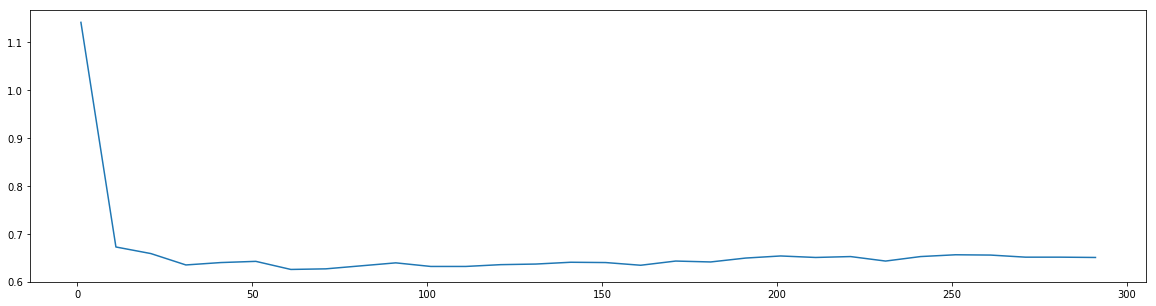

In [25]:
# n_estimators 学习曲线
mse = []
for i  in range(0,300,10):
    for train,test in kf.split(train_data):
        result = []
        rfc = RFC(n_estimators = i+1
                  ,random_state =10)
        Xtrain = train_data.iloc[train]
        Ytrain = target.iloc[train]
        Xtest  = train_data.iloc[test]
        Ytest  = target.iloc[test]
        rfc.fit(Xtrain, Ytrain)
        Y_pred = rfc.predict(Xtest)
        e = MSE(y_true = Ytest, y_pred= Y_pred)
        result.append(e)
    mse.append(np.mean(result))
    
print(min(mse), mse.index(min(mse))*10+1)

plt.figure(figsize = [20,5])
plt.plot(range(1,300,10),mse)
plt.show()

0.634375 15


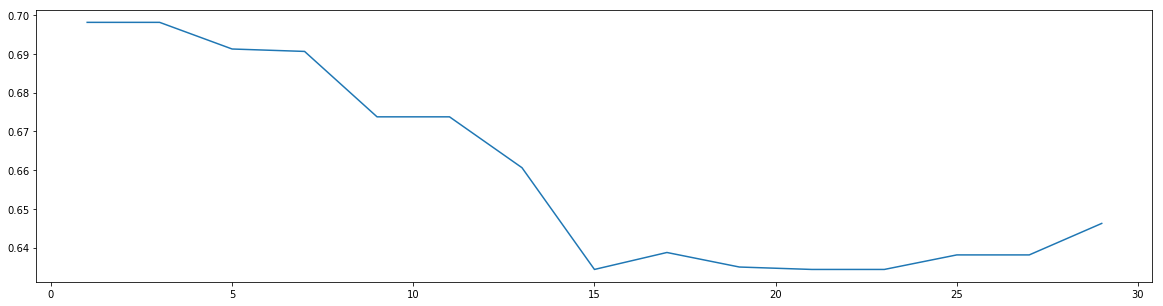

In [42]:
# 调整max_depth
mse = []
depth = np.arange(1,30,2)
for d in depth:
        for train,test in kf.split(train_data):
            result = []
            rfc = RFC(n_estimators = 61
                      ,random_state =10
                      ,max_depth =d
                     )
            Xtrain = train_data.iloc[train]
            Ytrain = target.iloc[train]
            Xtest  = train_data.iloc[test]
            Ytest  = target.iloc[test]
            rfc.fit(Xtrain, Ytrain)
            Y_pred = rfc.predict(Xtest)
            e = MSE(y_true = Ytest, y_pred= Y_pred)
            result.append(e)
        
        mse.append(np.mean(result))
print(min(mse),mse.index(min(mse))*2+1)

plt.figure(figsize=[20,5])
plt.plot(range(1,30,2),mse)
plt.show()

0.6 34


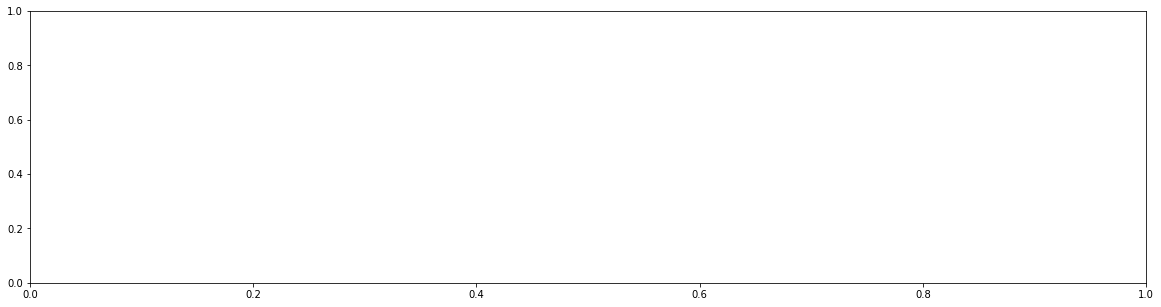

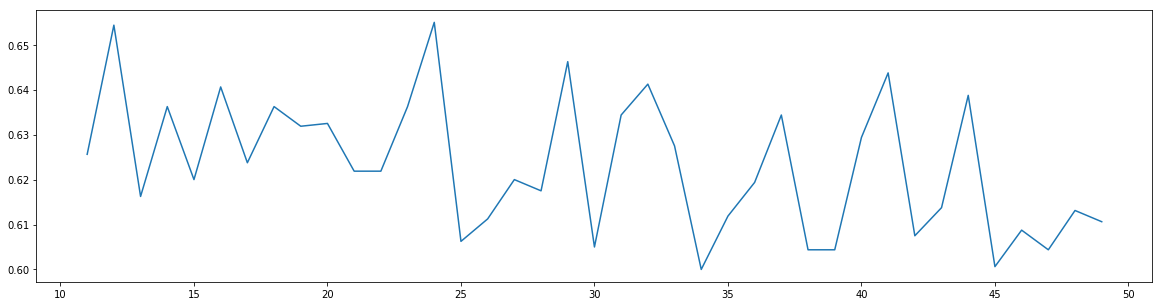

In [47]:
# 调整max_features
mse = []
features = np.arange(11,50)
for f in features:
        for train,test in kf.split(train_data):
            result = []
            rfc = RFC(n_estimators = 61
                      ,random_state =10
#                       ,max_depth = d
                      ,max_features = f
                     )
            Xtrain = train_data.iloc[train]
            Ytrain = target.iloc[train]
            Xtest  = train_data.iloc[test]
            Ytest  = target.iloc[test]
            rfc.fit(Xtrain, Ytrain)
            Y_pred = rfc.predict(Xtest)
            e = MSE(y_true = Ytest, y_pred= Y_pred)
            result.append(e)
        
        mse.append(np.mean(result))
print(min(mse),[*range(11,50)][mse.index(min(mse))])

plt.figure(figsize=[20,5])
plt.plot(range(11,50),mse)
plt.show()

In [49]:
# 调整完毕
# n_estimators =61 max_features = 34
kf = KFold(n_splits = 5)
rfc = RFC(n_estimators=61
          ,max_features = 34
          ,random_state = 10
         )
train_data = data[:train_shape]
mse = []
for train,test in kf.split(train_data):
    Xtrain = train_data.iloc[train]
    Ytrain = target.iloc[train]
    Xtest  = train_data.iloc[test]
    Ytest  = target.iloc[test]
    rfc.fit(Xtrain, Ytrain)
    Y_pred = rfc.predict(Xtest)
    e = MSE(y_true = Ytest, y_pred= Y_pred)
    mse.append(e)
print(np.mean(mse))

0.6055


In [30]:
data.head()

,id,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,...,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,age
0,1,1,12,32,59,1,1959,1,1,1,...,50,60.0,50,50,30.0,30,50,50,50,56
1,2,2,18,52,85,1,1992,1,1,1,...,90,70.0,70,80,85.0,70,90,60,60,23
2,3,2,29,83,126,2,1967,1,0,3,...,90,80.0,75,79,80.0,90,90,90,75,48
3,4,2,10,28,51,2,1943,1,1,1,...,100,90.0,70,80,80.0,90,90,80,80,72
4,5,1,7,18,36,2,1994,1,1,1,...,50,50.0,50,50,50.0,50,50,50,50,21


In [31]:
# 导出预测结果
train_data = data[:train_shape]
test_data = data[train_shape:]
rfc = RFC(n_estimators=61
          ,max_features = 34
          ,random_state = 10
         )
rfc.fit(train_data,target)
predict = rfc.predict(test_data)
result = pd.DataFrame({'id':test_data['id'],'happiness':predict},columns = ['id','happiness'],)
result.to_csv('happiness_submit.csv',index=None)


In [56]:
result['happiness'].value_counts()

4    2647
5     140
3     127
2      50
1       4
Name: happiness, dtype: int64